In [1]:
from itertools import islice

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

In [3]:
from gluonts.dataset.repository.datasets import get_dataset
from gluonts.dataset.common import ListDataset
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from pytorch_lightning.loggers import CSVLogger
from datasets import load_dataset

from estimator import TransformerEstimator

In [4]:
dataset = get_dataset("electricity")

In [5]:
estimator = TransformerEstimator(
        freq=dataset.metadata.freq,
        prediction_length=dataset.metadata.prediction_length,
        context_length=dataset.metadata.prediction_length*6,
        
        scaling=True,
        num_feat_static_cat=len(dataset.metadata.feat_static_cat),
        cardinality=[int(cat_feat_info.cardinality) for cat_feat_info in dataset.metadata.feat_static_cat],
        embedding_dimension=[3],
        
        nhead=2,
        num_encoder_layers=4,
        num_decoder_layers=2,
        dim_feedforward=16,
        activation="gelu",
        
        batch_size=256,
        num_batches_per_epoch=100,
        trainer_kwargs=dict(accelerator="gpu", max_epochs=50),
    )

In [6]:
predictor = estimator.train(
        training_data=dataset.train,
        shuffle_buffer_length=1024,
        cache_data=True,
    )

/home/kashif/.env/pytorch/lib/python3.10/site-packages/torch/nn/modules/transformer.py:218: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because self.layers[0].norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/kashif/.env/pytorch/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(
Authorization required, but no authorization protocol specified
Authorization required, but no authorization protocol specified
Authorization required, but no authorization protocol specified
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kashif

Training: 0it [00:00, ?it/s]

Epoch 0, global step 100: 'train_loss' reached 6.34899 (best 6.34899), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/transformer/lightning_logs/version_497/checkpoints/epoch=0-step=100.ckpt' as top 1
Epoch 1, global step 200: 'train_loss' reached 5.74684 (best 5.74684), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/transformer/lightning_logs/version_497/checkpoints/epoch=1-step=200.ckpt' as top 1
Epoch 2, global step 300: 'train_loss' reached 5.58337 (best 5.58337), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/transformer/lightning_logs/version_497/checkpoints/epoch=2-step=300.ckpt' as top 1
Epoch 3, global step 400: 'train_loss' reached 5.49624 (best 5.49624), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/transformer/lightning_logs/version_497/checkpoints/epoch=3-step=400.ckpt' as top 1
Epoch 4, global step 500: 'train_loss' reached 5.39838 (best 5.39838), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/transformer/l

In [7]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,
    predictor=predictor,
)

In [8]:
forecasts = list(forecast_it)

In [9]:
tss = list(ts_it)

In [10]:
evaluator = Evaluator()

In [11]:
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))

In [13]:
agg_metrics

{'MSE': 4082566.7612795923,
 'abs_error': 10705538.012435913,
 'abs_target_sum': 128632956.0,
 'abs_target_mean': 2385.272140631954,
 'seasonal_error': 189.49338196116761,
 'MASE': 0.7939232097365378,
 'MAPE': 0.09378300831825262,
 'sMAPE': 0.10933175413171485,
 'MSIS': 6.821186114698405,
 'QuantileLoss[0.1]': 4595112.704622474,
 'Coverage[0.1]': 0.03263610740246254,
 'QuantileLoss[0.2]': 7131244.40469833,
 'Coverage[0.2]': 0.0763239875389408,
 'QuantileLoss[0.3]': 8870875.223492026,
 'Coverage[0.3]': 0.1328437917222964,
 'QuantileLoss[0.4]': 10050478.835303709,
 'Coverage[0.4]': 0.20204717400979083,
 'QuantileLoss[0.5]': 10705538.056672756,
 'Coverage[0.5]': 0.2879951045838896,
 'QuantileLoss[0.6]': 10917865.700058911,
 'Coverage[0.6]': 0.37885699451120014,
 'QuantileLoss[0.7]': 10357532.761623424,
 'Coverage[0.7]': 0.49671784601691144,
 'QuantileLoss[0.8]': 8989805.6681166,
 'Coverage[0.8]': 0.633307372793354,
 'QuantileLoss[0.9]': 6457334.284624594,
 'Coverage[0.9]': 0.7954865746921

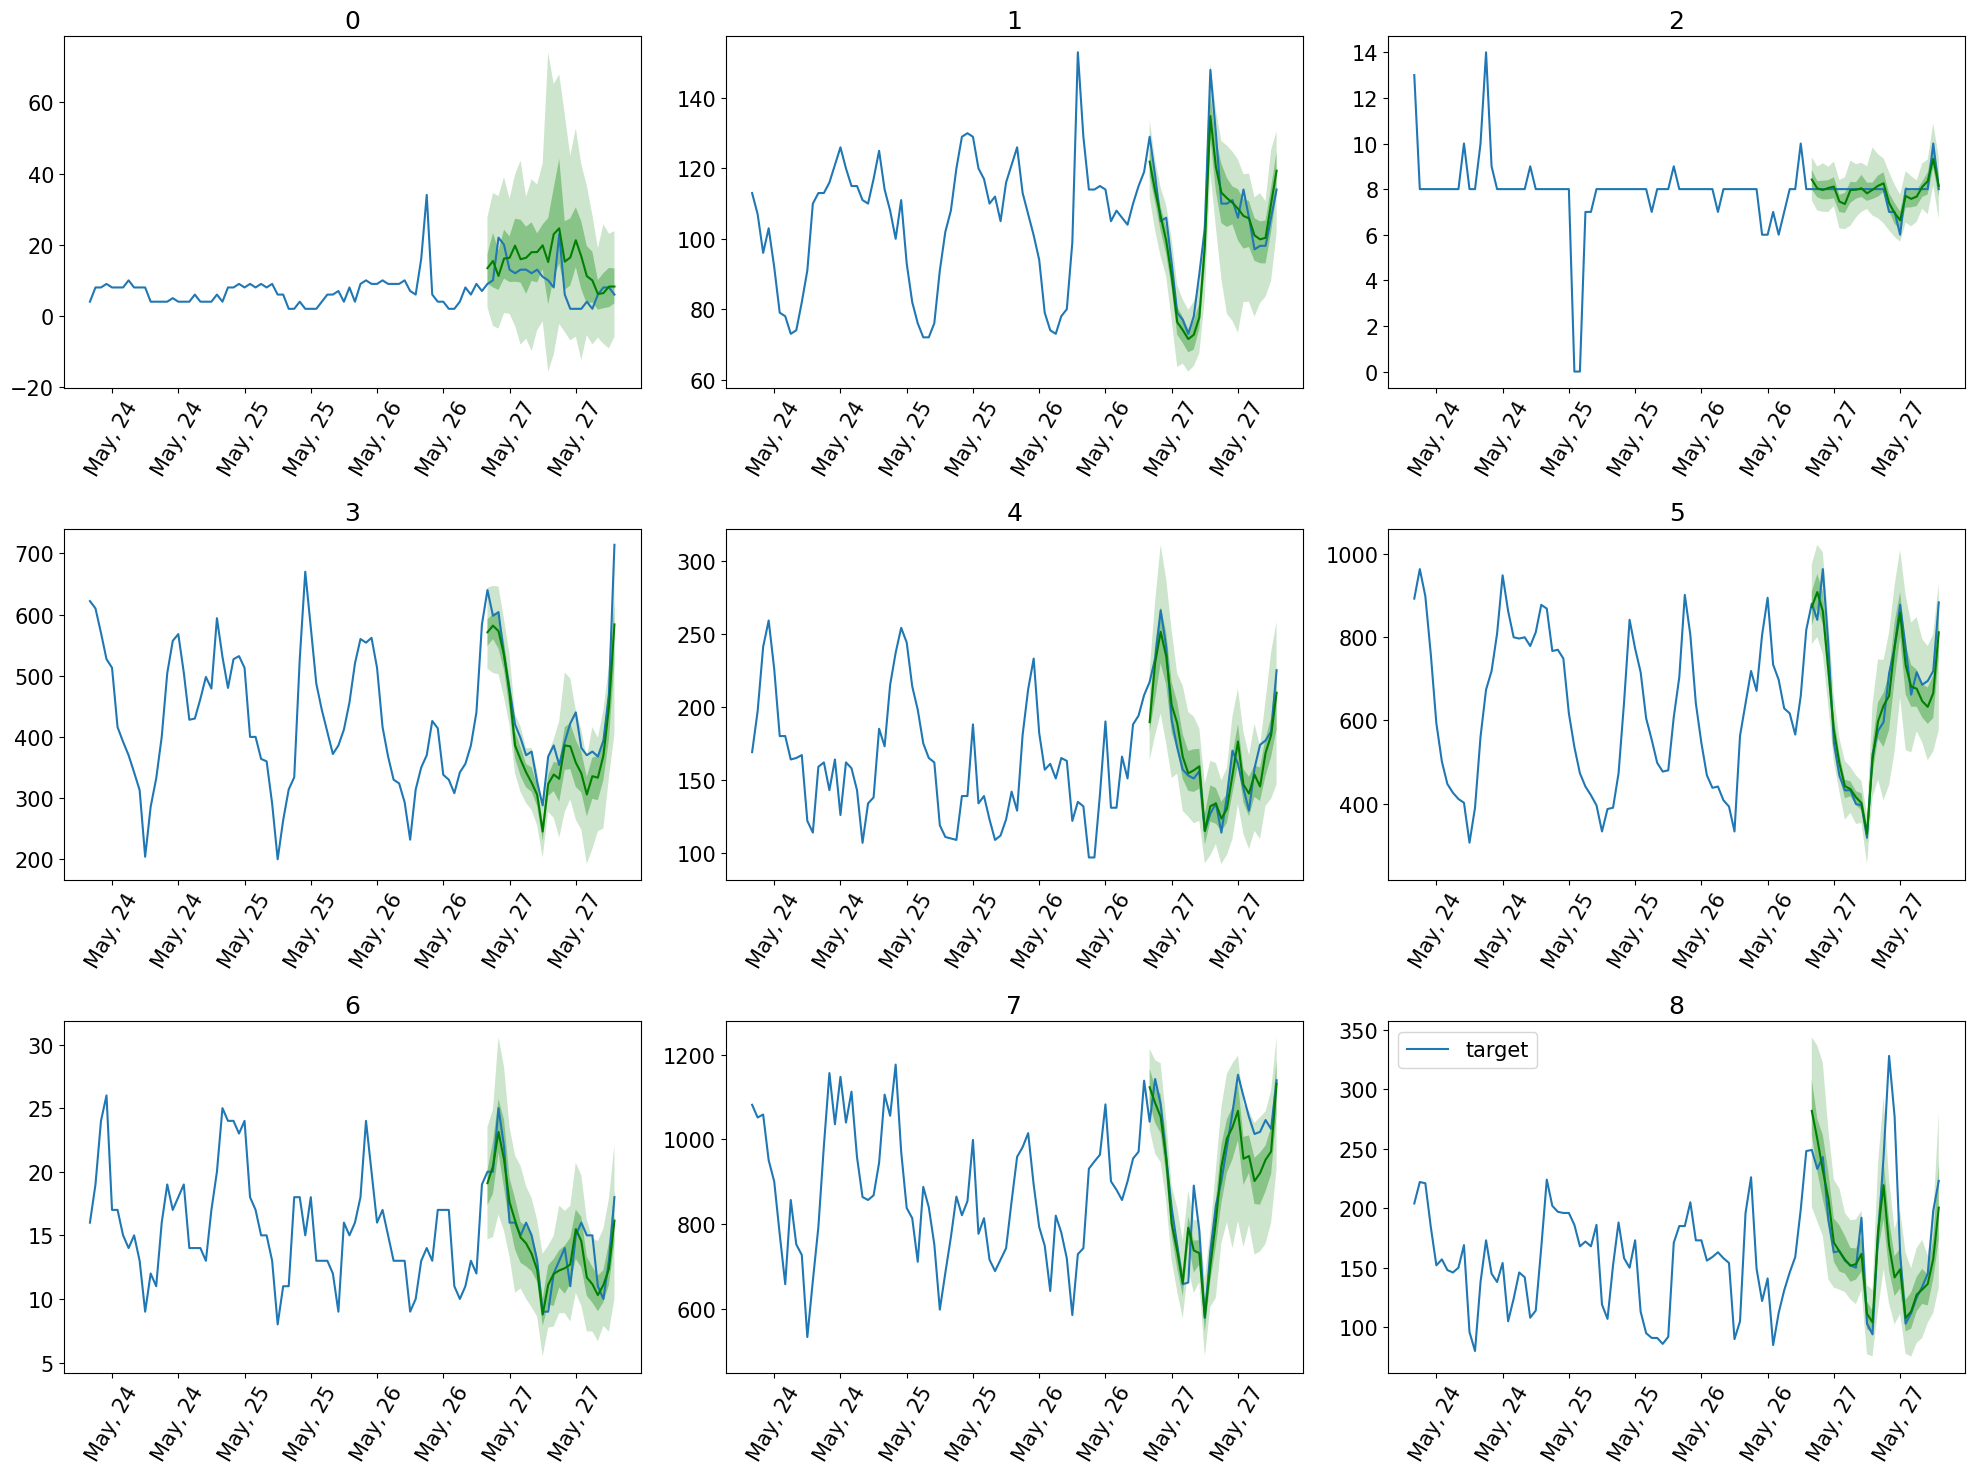

In [14]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * dataset.metadata.prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()